## ISE 535 Final Project

In [58]:
import numpy as np
import pandas as pd
import requests
import ipywidgets
import plotly.express as px
import warnings

import datetime

warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, interactive, widgets, interact_manual, fixed
from pandas import DataFrame
from IPython.display import HTML

from datetime import datetime

import folium
from folium import plugins



pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

layout = widgets.Layout(width='400px', height='30px')
pd.options.display.float_format = "{:.2f}".format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Function to Generate Latest Active Cases per Country


In [194]:
def countryData(country):
    url1 = "https://api.covid19api.com/dayone/country/"
    country = country
    url = url1+country
    payload={}
    headers = {'X-Access-Token': 'a3c98472-2928-4752-9d71-083ce072213c'}
    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()
    df = DataFrame(data)
    return df

### Summary of All Countries

In [268]:
url = "https://api.covid19api.com/countries"
payload={}
headers = {
    'X-Access-Token': 'a3c98472-2928-4752-9d71-083ce072213c'
}
response = requests.request("GET", url, headers=headers, data=payload)
data = response.json()
df = DataFrame(data).sort_values(by='Country')
df

,Country,Slug,ISO2
64,ALA Aland Islands,ala-aland-islands,AX
167,Afghanistan,afghanistan,AF
30,Albania,albania,AL
25,Algeria,algeria,DZ
134,American Samoa,american-samoa,AS
137,Andorra,andorra,AD
47,Angola,angola,AO
126,Anguilla,anguilla,AI
123,Antarctica,antarctica,AQ
104,Antigua and Barbuda,antigua-and-barbuda,AG


### Latest Cases for South East Asian Countries

In [61]:
seCountries = ["brunei","myanmar","cambodia","timor-leste","indonesia","malaysia", 
               "philippines","singapore","thailand","vietnam"]

In [62]:
def latestCountry(country):
    url1 = "https://api.covid19api.com/dayone/country/"
    country = country
    url = url1+country
    payload={}
    headers = {'X-Access-Token': 'a3c98472-2928-4752-9d71-083ce072213c'}
    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()
    df = DataFrame(data)
    return df.tail(1)

In [63]:
dataSE = []

for country in seCountries:
    df = latestCountry(country)
    columns = list(df)
    values = df.iloc[0]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    dataSE.append(a_dictionary)

In [328]:

dataSE = DataFrame(dataSE).sort_values('Country')
dataSE.head()

,ID,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,44d2d79f-a653-4e87-ab23-000907b9b728,Brunei Darussalam,BN,,,,4.54,114.73,13446,89,0,13357,2021-11-04T00:00:00Z
2,fd50d774-6ea3-4f96-8438-861c7f6de414,Cambodia,KH,,,,12.57,104.99,118787,2807,0,115980,2021-11-04T00:00:00Z
4,5b7a54cd-7fbc-4c91-be84-0b81a9ce4601,Indonesia,ID,,,,-0.79,113.92,4246174,143481,0,4102693,2021-11-04T00:00:00Z
5,ccfcde29-5d94-416d-a66c-0ba7b7a9ff85,Malaysia,MY,,,,4.21,101.98,2486630,29091,0,2457539,2021-11-03T00:00:00Z
1,1d056e82-f360-4aa6-b6e1-46d9a2653d41,Myanmar,MM,,,,21.91,95.96,502979,18744,0,484235,2021-11-04T00:00:00Z


### Latest Cases Table and Plot

In [65]:
#how to select columns and highlight dataframe using gradient background
dataFilter = dataSE[['Country','Confirmed','Deaths', 'Active']].sort_values('Confirmed', ascending=False).reset_index(drop=True)
dataFilter.style.background_gradient(cmap='Reds')


,Country,Confirmed,Deaths,Active
0,Indonesia,4246174,143481,4102693
1,Philippines,2793898,43586,2750312
2,Malaysia,2486630,29091,2457539
3,Thailand,1935442,19394,1916048
4,Viet Nam,939463,22283,917180
5,Myanmar,502979,18744,484235
6,Singapore,207975,442,207533
7,Cambodia,118787,2807,115980
8,Timor-Leste,19790,122,19668
9,Brunei Darussalam,13446,89,13357


In [66]:
variableSel = widgets.RadioButtons(
    options=['Confirmed', 'Deaths', 'Active'],
    value='Confirmed',
    description='Variable:',
    disabled=False
)

def scatterLatest(variable):
    fig = px.scatter(dataFilter, x='Country', y=variable, size=variable,
                color='Country', hover_name='Country', size_max=50,
                title=f"Latest Covid-19 {variable} Cases as of {dataSE['Date'][0]}")
    return fig.show()
    
interact(scatterLatest,variable=variableSel)


interactive(children=(RadioButtons(description='Variable:', options=('Confirmed', 'Deaths', 'Active'), value='…

<function __main__.scatterLatest(variable)>

In [67]:
map = folium.Map(location=[15,100], zoom_start=4, tiles='Stamenterrain')

for lat, lon, value, name in zip(dataSE['Lat'],dataSE['Lon'],dataSE['Active'],dataSE['Country']):
    folium.CircleMarker([lat, lon],radius=value*0.8, popup=(str(name).capitalize())).add_to(map)
#save map as hmtl, attach html to the readme file in gitpages

In [68]:
map.save(outfile= "map.html")

[maplink]("map.html")

### Big Data Set to Use with Widgets

In [69]:
#reading-in data
bigData = []
for country in seCountries:
    df = countryData(country)
    bigData.append(df)
bigData = pd.concat(bigData)

In [70]:
#cleaning and filtering
bigData = bigData[['Country', 'CountryCode','Confirmed','Deaths','Recovered','Active','Date']]
bigData['Date'] = pd.to_datetime(bigData.Date, format='%Y-%m-%d %H:%M:%S')
bigData['Date'] = bigData['Date'].dt.strftime('%Y-%m-%d')
bigData['Date']= pd.to_datetime(bigData["Date"])
bigData = bigData.reset_index(drop=True)

### Widgets

In [99]:
import datetime

countrySel = widgets.Dropdown(
    options=['Brunei Darussalam', 'Cambodia', 'Indonesia','Malaysia','Myanmar',
            'Philippines', 'Singapore', 'Thailand', 'Timor-Leste','Viet Nam'],
    value='Brunei Darussalam',
    description='Country:',
    disabled=False,
)

variableSel = widgets.Dropdown(
    options=['Confirmed', 'Deaths', 'Recovered', 'Active'],
    value='Confirmed',
    description='Variable:',
    disabled=False
)

#Dates entered are exclusive
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 12, 30)
startDateSel = widgets.DatePicker(description='Start Date:', disabled=False, value=start)
endDateSel = widgets.DatePicker(description='End Date:', disabled=False, value=end)

### Widgets Interact with Function to Filter Dataframe

In [100]:
def filter(country, variable, startDate, endDate):
    filter1 = bigData[bigData['Country'] == countrySel.value]
    filter2 = filter1[['Country', 'CountryCode', variableSel.value, 'Date']]
    filter3 = filter2[(filter2['Date']>pd.to_datetime(startDateSel.value)) & 
                   (filter2['Date']<pd.to_datetime(endDateSel.value))]
    fig = px.line(df, x=filter3['Date'], y=filter3[variable])
    return display(filter3.head()), fig.show()

widget = interact(filter, country=countrySel, variable=variableSel, startDate=startDateSel, endDate=endDateSel)


interactive(children=(Dropdown(description='Country:', options=('Brunei Darussalam', 'Cambodia', 'Indonesia', …

### Line Graphs

In [73]:
bigData.head()

,Country,CountryCode,Confirmed,Deaths,Recovered,Active,Date
0,Brunei Darussalam,BN,1,0,0,1,2020-03-09
1,Brunei Darussalam,BN,1,0,0,1,2020-03-10
2,Brunei Darussalam,BN,11,0,0,11,2020-03-11
3,Brunei Darussalam,BN,11,0,0,11,2020-03-12
4,Brunei Darussalam,BN,37,0,0,37,2020-03-13


function

### Plotting Directly from API

In [74]:
import plotly.express as px

In [276]:
data = countryData("Philippines")

In [277]:
#Create daily cases
data['DailyCases'] = data['Confirmed'].diff()
data = data.dropna()
data['DailyCases'] = data['DailyCases'].astype(int)


#Create daily deaths
data['DailyDeaths'] = data['Deaths'].diff()
data = data.dropna()
data['DailyDeaths'] = data['DailyDeaths'].astype(int)

In [278]:
fig = px.line(df, x=data['Date'], y=data['DailyCases'])
fig.show()

### Forecasting

In [279]:
data.tail()

,ID,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date,DailyCases,DailyDeaths
640,41cbb455-c858-4500-ab59-9cd350e27021,Philippines,PH,,,,12.88,121.77,2787276,43172,0,2744104,2021-10-31T00:00:00Z,3380,128
641,91d4b7e4-9c07-4c06-90e4-cb9e8f00979a,Philippines,PH,,,,12.88,121.77,2790375,43276,0,2747099,2021-11-01T00:00:00Z,3099,104
642,67e476c2-557b-4c80-8566-0ea144c49257,Philippines,PH,,,,12.88,121.77,2792656,43404,0,2749252,2021-11-02T00:00:00Z,2281,128
643,90dfbc2c-1928-4fc6-b1a7-a0038c3eb116,Philippines,PH,,,,12.88,121.77,2793898,43586,0,2750312,2021-11-03T00:00:00Z,1242,182
644,052849af-eb1c-44c7-9707-a4450a9aa412,Philippines,PH,,,,12.88,121.77,2793898,43586,0,2750312,2021-11-04T00:00:00Z,0,0


In [108]:
import warnings;
warnings.simplefilter('ignore')

In [111]:
from fbprophet import Prophet

In [183]:
data.describe()

,Confirmed,Deaths,Recovered,Active,DailyCases,DailyDeaths
count,642.00,642.00,642.00,642.00,642.00,642.00
mean,734288.97,12607.30,362562.18,359119.50,4351.86,67.89
std,791357.70,12418.67,441226.03,794729.75,5015.00,77.28
min,2.00,1.00,0.00,1.00,0.00,-2.00
25%,54731.25,1412.50,144.25,23394.00,986.50,10.25
50%,457303.00,8893.00,208443.00,44621.00,2236.50,40.00
75%,1206973.00,20519.25,523861.75,63586.50,6183.25,101.00
max,2793898.00,43586.00,1528422.00,2750312.00,27887.00,568.00


In [280]:
df = data[['DailyCases', 'Date']]
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date']= pd.to_datetime(df["Date"])
df.columns = ['y', 'ds']

In [281]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
model = m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [282]:
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)

In [283]:
forecast.head()
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
668,2021-11-30,11379.48,5087.68,13913.96,11338.58,11421.51,-1750.08,-1750.08,-1750.08,-663.21,-663.21,-663.21,-1086.87,-1086.87,-1086.87,0.00,0.00,0.00,9629.39
669,2021-12-01,11402.65,5553.08,14028.71,11359.53,11447.59,-1759.54,-1759.54,-1759.54,-601.45,-601.45,-601.45,-1158.09,-1158.09,-1158.09,0.00,0.00,0.00,9643.10
670,2021-12-02,11425.82,5543.37,14463.45,11379.81,11472.66,-1423.62,-1423.62,-1423.62,-188.81,-188.81,-188.81,-1234.81,-1234.81,-1234.81,0.00,0.00,0.00,10002.20
671,2021-12-03,11448.99,6450.08,15414.92,11401.08,11497.82,-656.75,-656.75,-656.75,658.79,658.79,658.79,-1315.54,-1315.54,-1315.54,0.00,0.00,0.00,10792.24
672,2021-12-04,11472.16,6170.69,15076.86,11422.28,11523.15,-815.96,-815.96,-815.96,582.80,582.80,582.80,-1398.76,-1398.76,-1398.76,0.00,0.00,0.00,10656.20


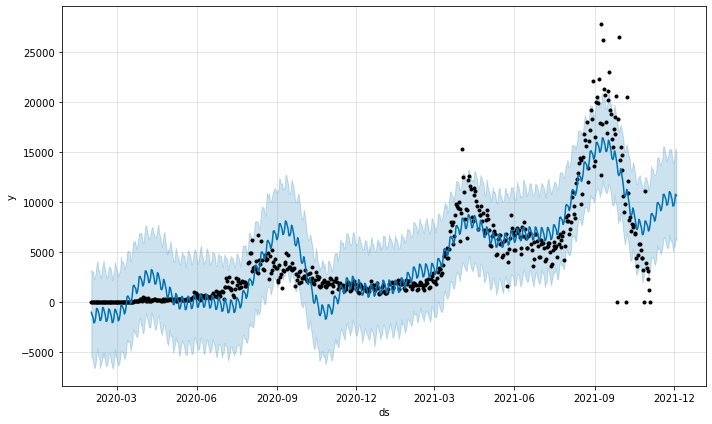

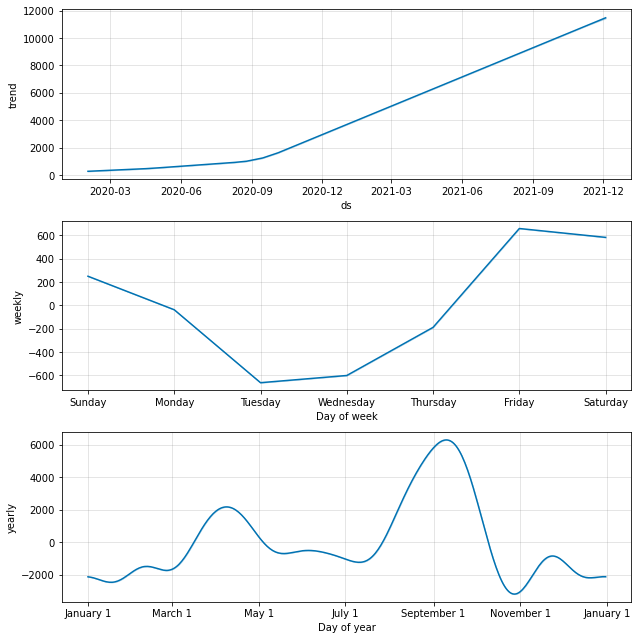

In [310]:
plot1 = m.plot(forecast)
plot2 = m.plot_components(forecast)

In [286]:
#predicting future forecast with date, upper and lower limit of y value
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
668,2021-11-30,9629.39,5087.68,13913.96
669,2021-12-01,9643.10,5553.08,14028.71
670,2021-12-02,10002.20,5543.37,14463.45
671,2021-12-03,10792.24,6450.08,15414.92
672,2021-12-04,10656.20,6170.69,15076.86


In [309]:
import plotly.graph_objs as go

fig = go.Figure([
    go.Scatter(
        name='Forecast',
        x=forecast['ds'],
        y=forecast['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=forecast['ds'],
        y=forecast['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=forecast['ds'],
        y=forecast['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        x=df['ds'], 
        y = df['y'], 
        mode='markers', 
        name='Actual'
    )
])
fig.update_layout(
    yaxis_title='Confirmed Cases',
    title='Actual and Forecasted Cases',
    hovermode="x"
)
fig.show()

### Testing Performance of Model via Cross Validation

In [323]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='570 days', period='7 days', horizon = '30 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2021-08-24 00:00:00 and 2021-10-05 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [326]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,39991977.25,6323.92,4758.25,0.22,0.34,0.38
1,4 days,48280506.36,6948.42,5511.47,0.31,0.38,0.33
2,5 days,36710669.19,6058.93,5074.68,0.31,0.31,0.33
3,6 days,59178971.59,7692.79,6455.66,0.36,0.45,0.29
4,7 days,49769737.52,7054.77,6042.70,0.36,0.45,0.24
